# Load data

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## A time series created by tracking the left-hand of a volunteer (Fig. 15)

![datahand](hand_move.png)

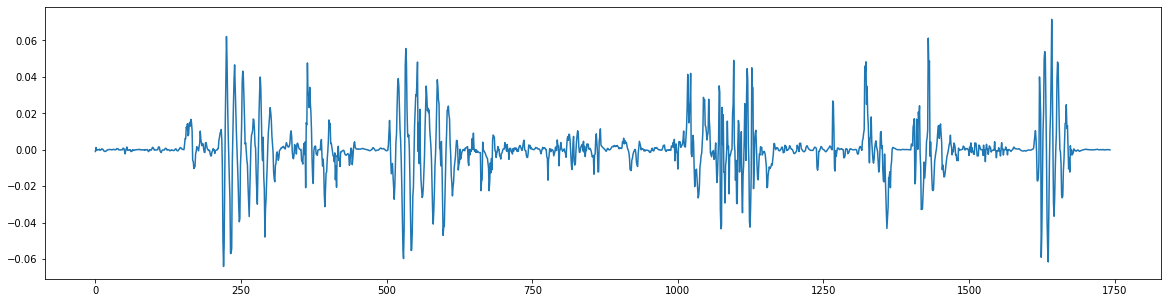

In [3]:
data_hand = np.loadtxt('dataset/a1va3.txt')[1:,1]
plt.figure(figsize=(20,5))
plt.plot(data_hand)
plt.show()

## A time series created by a hip-worn gyroscope (Fig. 16)

![datahip](gyroscope.png)

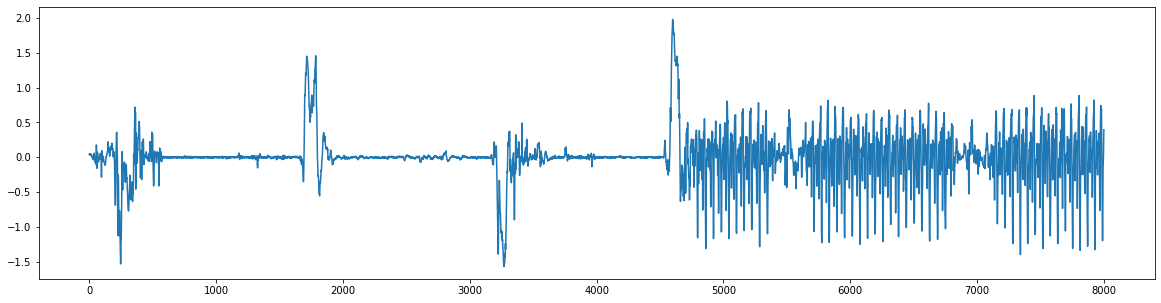

In [4]:
data_hip = np.loadtxt('dataset/gyroexp61user30_selected.txt')
plt.figure(figsize=(20,5))
plt.plot(data_hip)
plt.show()

# Code for SWAMP

## Table 2 LBKeoghDSMP

In [61]:
def paa(T, D):
    #T is a numpy float array or a numpy boolean array
    l = len(T)
    l_D = int(np.ceil(l/D))
    T_D = np.zeros(l_D)
    
    if type(T[0]) == np.bool_:
        T_D = T_D.astype('bool')
        for i in range(l_D):
            T_D[i] = np.all(T[i*D: (i+1)*D])
    elif type(T[0]) == np.float_:
        for i in range(l_D):
            T_D[i] = np.mean(T[i*D: (i+1)*D])
    else:
        raise AssertionError('Input should be a numpy array contians np.bool_ or np.float_')
    return T_D

In [106]:
# Calculate Keogh lowerbound for T and the envelopes around Q
def LB_Keo_dis(T, Up, Low):
    diff = np.maximum(T-Up, Low-T)
    diff = np.maximum(diff, np.zeros_like(T))
    return np.sum(diff**2)

In [242]:
def LB_Keo_MP(T, L, pruned, Up, Low):
    MP = 100 * np.ones(len(T)-L+1)
    LB_index = -1 * np.ones_like(MP).astype('int')
    
    # Calculate the lowest Keogh lowerbound for T_i,L
    for i in range(len(MP)):
        if pruned[i]: continue 
        # Calculate Keogh lowerbound for all T_i,L and T_j, L
        for j in range(len(MP)):
            if pruned[j] or abs(i-j)<L: continue
            dis = LB_Keo_dis(T[i: i+L], Up[j: j+L], Low[j: j+L])
            if dis < MP[i]:
                MP[i] = dis
                LB_index[i] = j     
    return MP, LB_index

In [292]:
# code for table 2
def LB_DSMP(T, L, D, pruned, Up, Low):
    T_D = paa(T, D)
    pruned_D = paa(pruned, D)
    L_D = int(np.floor(L*len(T_D)/len(T)))
    Up_D = paa(Up, D)
    Low_D = paa(Low, D)
    
    MP_D, LB_index = LB_Keo_MP(T_D, L_D, pruned_D, Up_D, Low_D)
    
    LBMP = np.repeat(MP_D, D)[:len(T)]
    LB_index = D * np.repeat(LB_index, D)[:len(T)] + D//2
    
    LBMP *= np.sqrt(len(T)/len(T_D))
    
    return LBMP, LB_index    

A simple test

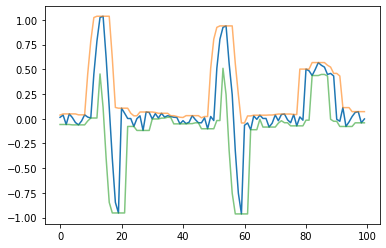

In [305]:
T = np.zeros(100)
signal = np.sin([0.5*i for i in range(10)])
noise = 0.5*np.ones(10)
T[10:20] = signal
T[50:60] = signal
T[80:90] = noise
T += 0.05*np.random.randn(100)
Up = np.zeros_like(T)
Low = np.zeros_like(T)
pruned = np.zeros_like(T).astype('bool')

for i in range(len(T)):
    left = max(0, i-2)
    right = min(len(T), i+3)
    Up[i] = np.max(T[left:right])
    Low[i] = np.min(T[left:right])
plt.plot(T)
plt.plot(Up,alpha=0.6)
plt.plot(Low,alpha=0.6)

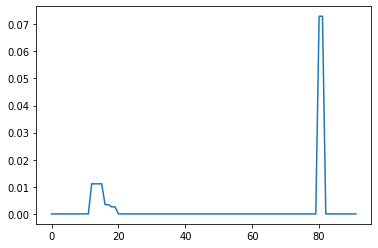

In [306]:
MP, LB_index = LB_DSMP(T, 10, 2, pruned, Up, Low)
plt.plot(MP)
plt.show()

## Table 1 ComputeDSMP

In [310]:
# Using Euclidean Distance to calculate matrix profile
# Here is a simple version. Furthur we can use FFT to speed up
def ComputeMatrixProfile(T, L):
    #time series T, subsequence length L
    ED_mp = 100 * np.ones(len(T)-L+1)
    ED_index = -1 * np.ones_like(MP).astype('int')
    for i in range(len(ED_mp)):
        for j in range(len(ED_mp)):
            if abs(i-j)<L: continue
            dis = np.sum((T[i:i+L] - T[j:j+L])**2)
            if dis < ED_mp[i]:
                ED_mp[i] = dis
                ED_index[i] = j
    return ED_mp, ED_index
    

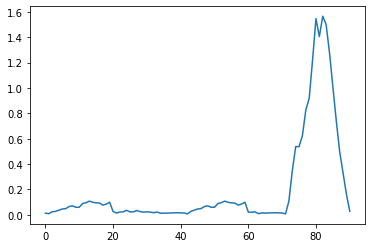

In [311]:
ED_mp,_ = ComputeMatrixProfile(T, 10)
plt.plot(ED_mp)

In [9]:
# Calculate DTW distance between A and B
def dtw_distance(A, B, w):
    # time series A and B, warping window size w
    # TO DO
    return dtw
    

In [312]:
# Calculate upper and lower envelope 
def cal_envelop(T, w):
    Up = np.zeros_like(T)
    Low = np.zeros_like(T)
    pruned = np.zeros_like(T).astype('bool')

    for i in range(len(T)):
        left = max(0, i-w)
        right = min(len(T), i+w+1)
        Up[i] = np.max(T[left:right])
        Low[i] = np.min(T[left:right])
    return Up, Low

In [299]:
def ComputeDSMP(T, L, w):
    #time series T, subsequence length L, warping window size w
    ED_mp, ED_index = ComputeMatrixProfile(T, L)
    ED_i = np.argmin(ED_mp)
    ED_j = ED_index[ED_i]
    best_so_far = dtw_distance(T[ED_i: ED_i+L], T[ED_j: ED_j+L], w)
    
    D = L
    pruned = np.zeros_like(T).astype('bool')
    Up, Low = cal_envelop(T, w)
    
    while D>0:
        LBMP, LB_index = LB_DSMP(T, L, D, pruned, Up, Low)
        LB_i = np.argmin(LBMP)
        LB_j = LB_index[LB_i]
        LB_motif_dist = dtw_distance(T[LB_i: LB_i+L], T[LB_j: LB_j+L], w)
        if LB_motif_dist < best_so_far:
            best_so_far = LB_motif_dist
            pruned[LBMP > best_so_far] = True
            
        D = int(np.floor(D/2))
    return LBMP, pruned, best_so_far, LB_index

## Table 3 SWAMP

In [11]:
def SWAMP(T, L, w):
    return motif_pair, best_dtw_dis